## Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
import datetime
import re

## Import Dataset

In [2]:
df = pd.read_csv('data_collection/data.csv')
df.shape

(145, 4)

In [3]:
#drop all rows with missing articles
df.dropna(inplace=True)


In [4]:
df.shape

(144, 4)

## Data Cleaning / Preprocessing

In [5]:
#create a function that removes any puncuation and numbers and converts all letters to lower case
import re

def clean_text(string):
    clean_text = re.sub("[^a-zA-Z\s]", " ", string)
    #covert all test to lowercase
    lower_text = clean_text.lower()
    single_white_space_text = re.sub("\s+", " ", lower_text)
    return single_white_space_text

In [6]:
#apply clean_text function to every article and create new feature

df['clean_text'] = df.text.apply(lambda x: clean_text(x))


In [7]:
#now lets tokenize each review so we have a list of words for each document

def text_preprocessor(string):
    tokenize_review = string.split()
    word_list = []
    #let's remove any word that has less than 3 letters. this will take care of indefinite articles and former contractions that 
    #resulted in single letter words after removing punctuations.
    for word in tokenize_review:
        if len(word) > 2:
            word_list.append(word)
    #now let's remove english stopwords
    filtered_wordlist = []
    for word in word_list:
        if word not in stopwords.words('english'):
            filtered_wordlist.append(word)
    #now let's lemmatize each item so that words with similar inflections will be counted as one item
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    for word in filtered_wordlist:
        lemmatized_words.append(lemmatizer.lemmatize(word))

    return lemmatized_words                        
        

    

In [8]:
#now let's apply the the text_preprocessor to each article and create a new feature

df['processed_text'] = df.clean_text.apply(lambda x: text_preprocessor(x))

### Datetime

In [10]:
#After closer investigation of the article publish date, I noticed that the date is in a string format and has alot of extra
#characters that are unnecessary. Firstly, let use regex to clean it up a bit before we change the data type

df['date'] = df.date.apply(lambda x: x[11:23])


In [11]:
#now that we got that cleaned up, let's convert the string to a datetime object
df['date'] = pd.to_datetime(df['date'])

### Save cleaned dataframe to new csv file

In [15]:
df.to_csv('clean_df.csv')

### Open clean dataframe

In [51]:
df1 = pd.read_csv('clean_df.csv', index_col=0)


## Feature Engineering

In [52]:
#let's create a new date column so that we can look at the distribution of reviews written by month

df1['YearMonth'] = pd.to_datetime(df1['date']) - pd.offsets.MonthBegin(1)

## Exploratory Analysis

### How Regular Staff Writers Does The Verge Have?

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

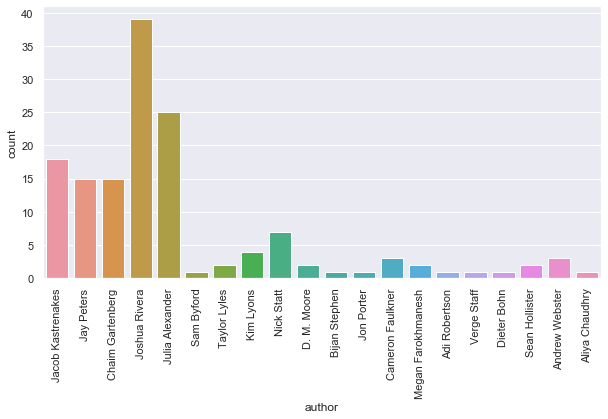

In [32]:
plt.figure(figsize=(10,5))
sns.countplot(data=df1, x='author' )
plt.xticks(rotation=90)


 
Looking at the chart below there is a pretty significant dropoff after the first 5 writers, so we're gonna let 15 be the threshold for being a "regular" staff writer

### How many reviews were published for each month?

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

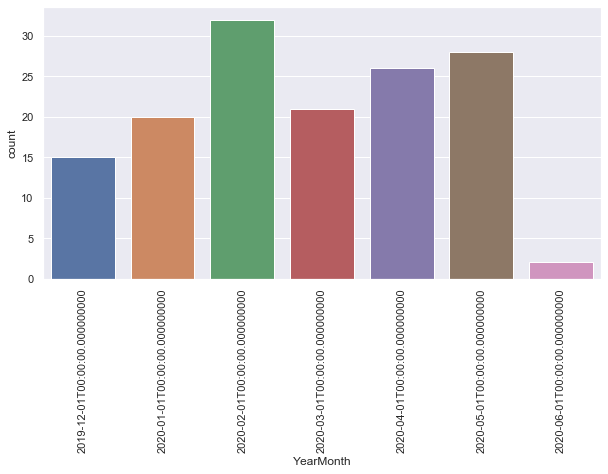

In [62]:
plt.figure(figsize=(10,5))
sns.countplot(data=df1, x='YearMonth')
plt.xticks(rotation=90)

 
Looks like February is the peak of number of posts but dropped dramatically a month later. Makes sense since March is when the coronavirus pandemic shutdown most of the country (and World). 
Let's examine the number of writers that were active for each month and see if there's a correlation


### How many writers were active during this time?

In [67]:
author_month_df = df1.groupby('YearMonth')['author'].count().reset_index()

In [70]:
author_month_df

# plt.figure(figsize=(10,5))
# sns.barplot(data=author_month_df, x='author', y='YearMonth')
# plt.xticks(rotation=90)

,YearMonth,author
0,2019-12-01,15
1,2020-01-01,20
2,2020-02-01,32
3,2020-03-01,21
4,2020-04-01,26
5,2020-05-01,28
6,2020-06-01,2
